In [131]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from item_embedding import item_encode

In [132]:
conn = pymysql.connect(host = '127.0.0.1', 
                       user = 'root', 
                       password = 'root123', 
                       db = 'delidou')

df = pd.read_sql_query('select * from base_goods', conn)

In [133]:
encoded_items,df = item_encode(df)
df = df.reset_index(drop = True)

In [134]:
link_to_location = {link_id:location for location, link_id in df['link_id'].reset_index().values}

In [135]:
n_users = df['id'].nunique()
n_items = df.link_id.nunique()
n_pref = df.shape[0]

print('Number of users: {}'.format(n_users))
print('Number of items: {}'.format(n_items) )
print('Number of records: {}'.format(n_pref))



Number of users: 6193
Number of items: 110656
Number of records: 179371


In [136]:
item_count = df.groupby('link_id')['id'].agg(lambda x:len(set(x))).reset_index().sort_values(by = 'id',ascending = False)
top_link_ids = item_count[item_count.id > 10].link_id.values
user_count = df.groupby('id')['link_id'].agg(lambda x:len(set(x))).reset_index().sort_values(by = 'link_id',ascending = False)
top_user_ids = user_count[user_count.link_id > 10].id.values

### USER features

In [137]:
from preprocess_user import make_user_fans_pipeline
from etl import load_user_info_features
from etl import load_fans_info_features

user = load_user_info_features()
fans = load_fans_info_features()
user_fans = user.merge(fans, on = 'id', how = 'inner')
pipe = make_user_fans_pipeline(30)
user_features = pipe.fit_transform(user_fans)

In [138]:
df.shape, len(encoded_items)

((179371, 13), 179371)

In [139]:
df = df[(df.id.isin(top_user_ids)) & (df.link_id.isin(top_link_ids)) & (df.id.isin(user_fans.id.values))]

In [140]:
ratings = df[['id','link_id']].copy()
ratings['rating'] = 1

ratings = ratings.rename(columns = {'id':'user_id','link_id':'item_id'})
user2id = {user:i for i, user in enumerate(ratings.user_id.unique())}
item2id = {item:i for i, item in enumerate(ratings.item_id.unique())}
ratings['user_id'] = ratings['user_id'].replace(user2id)
ratings['item_id'] = ratings['item_id'].replace(item2id)

### USER

In [141]:
result = []
for user, f  in zip(user_fans.id.values, user_features):
    if user in user2id.keys():
        result.append([user2id[user],*f])
        
user_features = pd.DataFrame(result)
user_features.columns = ['user_id' if col == 0 else 'F_' + str(col) for col in user_features]
user_features = user_features.iloc[:,1:]

In [142]:
all_items = set(ratings.item_id.unique())

In [143]:
n_negative = 50
negative_samples = []
for user_id in ratings.user_id.unique():
    user_items = set(ratings[ratings.user_id == user_id]['item_id'].tolist())
    space = list(all_items.difference(set(user_items)))
    neg_items = np.random.choice(space, size = n_negative)
    for neg_item in neg_items:
        negative_samples.append([user_id, neg_item,0])
neg_ratings = pd.DataFrame(negative_samples,columns = ['user_id','item_id','rating'])

In [144]:
dataset = pd.concat([ratings, neg_ratings])

In [145]:
dataset

,user_id,item_id,rating
15,0,0,1
24,0,1,1
33,0,2,1
34,0,3,1
35,0,4,1
...,...,...,...
143245,2864,785,0
143246,2864,573,0
143247,2864,777,0
143248,2864,203,0


In [146]:
itemid_to_location = {id_:link_to_location[link]for link,id_ in item2id.items()}

In [147]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test =  train_test_split(dataset[['user_id','item_id']], 
                                                    dataset['rating'], 
                                                    test_size = 0.1, 
                                                    shuffle = True)

item_encode_train = encoded_items[X_train.item_id.values]
item_encode_test = encoded_items[X_test.item_id.values]

In [148]:
item_encode_test.shape, X_test.shape

((16888, 128), (16888, 2))

---------------------

In [149]:
user_feature_train = user_features.iloc[X_train.user_id.values,:]
user_feature_test = user_features.iloc[X_test.user_id.values,:]

In [150]:
N = ratings.user_id.nunique()
M = ratings.item_id.nunique()
K = 10

In [151]:
from tensorflow.keras.layers import Input, Embedding, Dot, Add,Flatten,Dense,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

In [152]:
reg = 0.

In [153]:
user_input = Input(1,)
item_input = Input(1,)
encoded_items_tensor = Input(128,)
input_user_feature = Input(127,)

user_embedding = Embedding(N,K, embeddings_regularizer=l2(reg))(user_input)
item_embedding = Embedding(M,K, embeddings_regularizer=l2(reg))(item_input)

user_bias = Embedding(N,1, embeddings_regularizer=l2(reg))(user_input)
item_bias = Embedding(M,1, embeddings_regularizer=l2(reg))(item_input)

rating_pred = Dot(axes = 2)([user_embedding, item_embedding])
rating_pred = Add()([rating_pred, user_bias, item_bias])
rating_pred = Flatten()(rating_pred)
rating_pred = Concatenate()([rating_pred,encoded_items_tensor,input_user_feature])
rating_pred = Dense(16, activation = 'relu')(rating_pred)
rating_pred = Dense(1, activation = 'sigmoid')(rating_pred)

model = Model([user_input, item_input,encoded_items_tensor,input_user_feature],rating_pred)

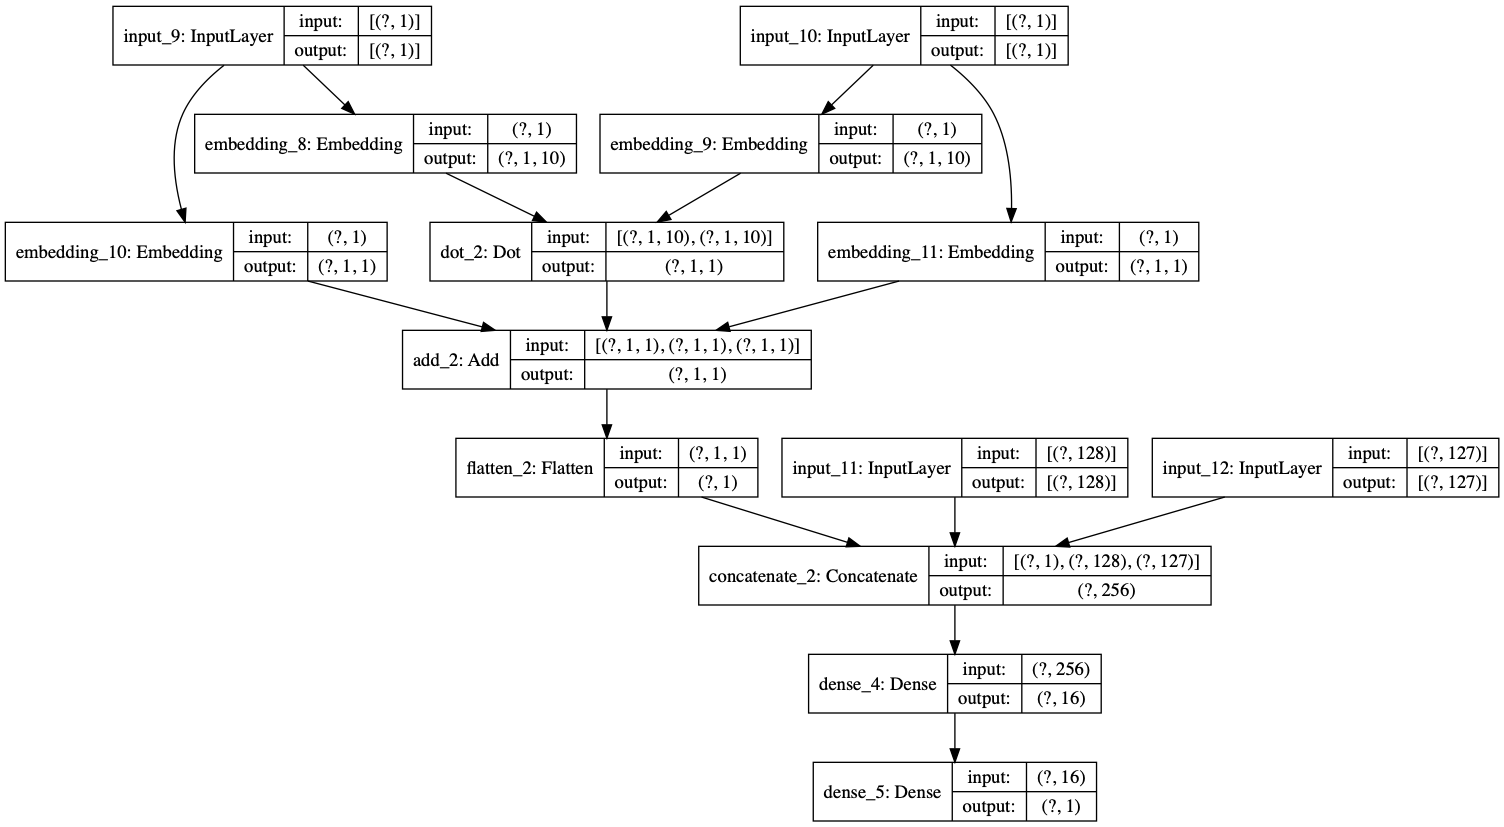

In [154]:
plot_model(model,show_shapes = True)

In [155]:
X_train.user_id.values.shape
X_train.item_id.values.shape
item_encode_train.shape
user_feature_train.shape

(151987, 127)

In [156]:
from tensorflow.keras.optimizers import SGD,Adam
import tensorflow as tf

In [157]:
model.compile(optimizer = Adam(lr = 0.001),loss = tf.keras.losses.BinaryCrossentropy(),metrics = ['accuracy'])

In [158]:
EPOCHS = 20

In [159]:
history = model.fit(x = [X_train.user_id.values,X_train.item_id.values,item_encode_train,user_feature_train.values],y = y_train.values,
                   epochs = EPOCHS,
                   batch_size = 1024,
                   validation_data = (
                   [X_test.user_id.values,X_test.item_id.values,item_encode_test,user_feature_test], y_test.values)
                   )

Train on 151987 samples, validate on 16888 samples
Epoch 1/20
151987/151987 [==============================] - 1s 9us/sample - loss: 0.4301 - accuracy: 0.8480 - val_loss: 0.4207 - val_accuracy: 0.8471
Epoch 2/20
151987/151987 [==============================] - 1s 4us/sample - loss: 0.4143 - accuracy: 0.8484 - val_loss: 0.4109 - val_accuracy: 0.8471
Epoch 3/20
151987/151987 [==============================] - 1s 4us/sample - loss: 0.3957 - accuracy: 0.8488 - val_loss: 0.3873 - val_accuracy: 0.8512
Epoch 4/20
151987/151987 [==============================] - 1s 4us/sample - loss: 0.3470 - accuracy: 0.8628 - val_loss: 0.3490 - val_accuracy: 0.8671
Epoch 5/20
151987/151987 [==============================] - 1s 4us/sample - loss: 0.2896 - accuracy: 0.8882 - val_loss: 0.3259 - val_accuracy: 0.8826
Epoch 6/20
151987/151987 [==============================] - 1s 4us/sample - loss: 0.2475 - accuracy: 0.9048 - val_loss: 0.3128 - val_accuracy: 0.8870
Epoch 7/20
151987/151987 [=======================

In [160]:
from sklearn.metrics import confusion_matrix,roc_auc_score

In [161]:
preds = (model.predict(x = [X_test.user_id.values,X_test.item_id.values,item_encode_test, user_feature_test]) > 0.5).flatten()

In [162]:
confusion_matrix(y_test, preds)

array([[13426,   879],
       [ 1136,  1447]])

In [163]:
roc_auc_score(y_test, preds)

0.7493771349058176

In [164]:
id2user = {v:k for k,v in user2id.items()}
id2item = {v:k for k,v in item2id.items()}

In [209]:
user = np.random.choice(X_test.user_id)
user = np.repeat([user],len(all_items))  

recos = np.argsort(model.predict([user, np.array(list(all_items)),encoded_items[list(all_items),],user_features.iloc[user].values]).flatten())[::-1][:30]
df[df['id'] == id2user[user[0]]]

for reco in recos:
    print(df[df.link_id == id2item[reco]]['name'].iloc[0])

【助力湖北】周黑鸭鸭脖180g*2锁骨190g鸭掌140g武汉特产 共四盒
【助力湖北】武汉扬子江法饼1.2kg/绿豆糕330g/湖北味道1328g
【助力湖北】良仁潜江小龙虾 2020新虾 750g*2 包邮
150件儿童画笔绘画套装
TOI图益磁力拼图儿童益智磁性玩具早教宝宝书男孩女孩3-4-5-6岁
【助力湖北】蔡林记热干面5人份/675g+小菜30g*5
神笔小马良3d打印笔儿童立体绘画涂鸦画册低温耗材三d学生不烫手
荣景优品 4册 四大名著(注音彩图版)红楼梦三国演义水浒传西游记
【助力湖北】洪湖清水 麻辣、十三香小龙虾600g 2盒装
荣景优品 全5册教育孩子的书 好妈妈不吼不叫正面管教胜过好老师
婴儿自动吸发理发器充电静音超宝宝剃头小孩儿童剃发器推剪头神器
【TERGOO】蓝牙耳机 重低音颈挂式游戏运动耳机苹果安卓通用
荣景优品 5册好妈妈胜过好老师正面管教不吼不叫儿童情绪心理学
【助力湖北】襄阳襄梦手工锅巴400g*2袋/400g*4袋两口味可选包邮
【精选好课】0基础教你学会用剪映做视频剪辑
【一茶】儿童绘本 小学生课外读物 1-6年级 励志成长（全十册）
【一茶】婚姻不只一张床还有理解与爱   两性 情感 婚恋 恋爱
【南京同仁堂】金银花菊花决明子茶 多盒装 正品好茶分享
【助力湖北】公安县东南醇牛肉牛三鲜火锅950g加热即食包邮
【助力湖北】襄阳玉保溏心松花皮蛋精选20枚装单枚65克以上
【南京同仁堂】赤小豆红豆薏米茶 多盒装 正品好茶分享
推荐：魔幻水晶琉璃时尚无线蓝牙音箱 蓝牙5.0低音音响
【手环数据线】便携数据线 手环数据线 苹果安卓数据线
【助力湖北】洪湖农家藕汤900g/泡藕带400g/原味藕带500g 包邮
2斤/3斤【蜜之番】新疆吐鲁番特产10色10味葡萄干 1000g
ZW网红龙虾尾 麻辣/蒜蓉罐装包邮 香辣虾球熟食海鲜小龙虾零食
havit i39 蓝牙运动无线双耳入耳挂脖式耳机【所有手机通用】
【助力湖北】神农架林区 蜂之巢 神农百花蜜 350g/瓶 包邮
新款磁吸数据线安卓type-c苹果USB流光线手机充电线
好书分享博弈论墨菲定律鬼谷子羊皮卷人性弱点受益一生正版图书


In [210]:
df[df['id'] == id2user[user[0]]]['name'].unique().tolist()

['havit I6隐形超小蓝牙耳机无线挂耳运动开车单入耳头超长待机',
 '【坏果包赔】【催熟后食用】广西新鲜金煌芒果 5/10斤',
 '【今日好货】【鲜果坊】山东新古沙洲沙土地蜜薯香甜红薯5斤10斤',
 '【助力湖北】周黑鸭鸭脖180g*2锁骨190g鸭掌140g武汉特产 共四盒',
 '全球精选坚果果干-良品铺子全能妈妈综合果仁750g',
 '淘天然 ll  螺蛳粉 280g*3袋 280g*5袋 280g*10袋',
 '推荐：魔幻水晶琉璃时尚无线蓝牙音箱 蓝牙5.0低音音响',
 '【助力湖北】良仁潜江小龙虾 2020新虾 750g*2 包邮',
 'havit i39 蓝牙运动无线双耳入耳挂脖式耳机【所有手机通用】']